In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 47 kB/s 
     |████████████████████████████████| 199 kB 55.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=758cdf4b14a9b860f423be9107f6b1c118646c8332074937180f715fb0350c89
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('9_NPL3_Sentiment Analysis ').getOrCreate()

file_location = "/content/drive/MyDrive/K20411/Học Kỳ 5/02. Big Data/01. Practice/Practice10/Bản sao của 9_financial_news.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
df = spark.read.format(file_type) \
 .option("inferSchema", infer_schema) \
 .option("header", first_row_is_header) \
 .option("sep", delimiter) \
 .load(file_location)
df.show(5,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|News                                                                                                                                                                                                                                               |Sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|- BEIJING XFN-ASIA - Hong Kong-listed Standard Chartered Bank said it has signed a China mobile phone dealer financing agreement with Nokia , making it the first foreign bank to offer financing to the country 's small and medium en

In [36]:
df.count()

962

In [37]:
# Remove non ASCII characters

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import re

# remove non ASCII characters
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [38]:
# check the function:
df = df.withColumn('News_non_asci',strip_non_ascii_udf(df['News']))
df.show(5)

+--------------------+---------+--------------------+
|                News|Sentiment|       News_non_asci|
+--------------------+---------+--------------------+
|- BEIJING XFN-ASI...|        1|- BEIJING XFN-ASI...|
|- Operating profi...|        1|- Operating profi...|
|- Provides summar...|        0|- Provides summar...|
|- So , the sales ...|        0|- So , the sales ...|
|- UPM-Kymmene upg...|        1|- UPM-Kymmene upg...|
+--------------------+---------+--------------------+
only showing top 5 rows



In [39]:
# fixed abbreviation
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str

fix_abbreviation_udf = udf(fix_abbreviation, StringType())

In [40]:
df = df.withColumn('News_fixed_abbrev',fix_abbreviation_udf(df['News']))
df.show(5,True)

+--------------------+---------+--------------------+--------------------+
|                News|Sentiment|       News_non_asci|   News_fixed_abbrev|
+--------------------+---------+--------------------+--------------------+
|- BEIJING XFN-ASI...|        1|- BEIJING XFN-ASI...|- beijing xfn-asi...|
|- Operating profi...|        1|- Operating profi...|- operating profi...|
|- Provides summar...|        0|- Provides summar...|- provides summar...|
|- So , the sales ...|        0|- So , the sales ...|- so , the sales ...|
|- UPM-Kymmene upg...|        1|- UPM-Kymmene upg...|- upm-kymmene upg...|
+--------------------+---------+--------------------+--------------------+
only showing top 5 rows



In [41]:
def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    # remove unwanted space, *.split() will automatically split on
    # whitespace and discard duplicates, the " ".join() joins the
    # resulting list into one string.
    return " ".join(cleaned_str.split())
# setup pyspark udf function
remove_features_udf = udf(remove_features, StringType())

In [42]:
df = df.withColumn('News_Cleaned',remove_features_udf(df['News_fixed_abbrev']))
df.show(5,True)

+--------------------+---------+--------------------+--------------------+--------------------+
|                News|Sentiment|       News_non_asci|   News_fixed_abbrev|        News_Cleaned|
+--------------------+---------+--------------------+--------------------+--------------------+
|- BEIJING XFN-ASI...|        1|- BEIJING XFN-ASI...|- beijing xfn-asi...|beijing xfn asia ...|
|- Operating profi...|        1|- Operating profi...|- operating profi...|operating profit ...|
|- Provides summar...|        0|- Provides summar...|- provides summar...|provides summary ...|
|- So , the sales ...|        0|- So , the sales ...|- so , the sales ...|so the sales grow...|
|- UPM-Kymmene upg...|        1|- UPM-Kymmene upg...|- upm-kymmene upg...|upm kymmene upgra...|
+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [43]:
# Sentiment Analysis main function
!pip install textblob
from pyspark.sql.types import FloatType
from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis , FloatType())
df  = df.withColumn("sentiment_score", sentiment_analysis_udf( df['News_Cleaned'] ))
df.show(5,True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+--------------------+---------+--------------------+--------------------+--------------------+---------------+
|                News|Sentiment|       News_non_asci|   News_fixed_abbrev|        News_Cleaned|sentiment_score|
+--------------------+---------+--------------------+--------------------+--------------------+---------------+
|- BEIJING XFN-ASI...|        1|- BEIJING XFN-ASI...|- beijing xfn-asi...|beijing xfn asia ...|       -0.03125|
|- Operating profi...|        1|- Operating profi...|- operating profi...|operating profit ...|            0.6|
|- Provides summar...|        0|- Provides summar...|- provides summar...|provides summary ...|            0.0|
|- So , the sales ...|        0|- So , the sales ...|- so , the sales ...|so the sales grow...|            0.1|
|- UPM-Kymmene upg...|        1|- UPM-Kymmene upg...|- upm-kymmene upg...|upm kymmene upgra...|            0.0|
+----

In [44]:
df.show()

+--------------------+---------+--------------------+--------------------+--------------------+---------------+
|                News|Sentiment|       News_non_asci|   News_fixed_abbrev|        News_Cleaned|sentiment_score|
+--------------------+---------+--------------------+--------------------+--------------------+---------------+
|- BEIJING XFN-ASI...|        1|- BEIJING XFN-ASI...|- beijing xfn-asi...|beijing xfn asia ...|       -0.03125|
|- Operating profi...|        1|- Operating profi...|- operating profi...|operating profit ...|            0.6|
|- Provides summar...|        0|- Provides summar...|- provides summar...|provides summary ...|            0.0|
|- So , the sales ...|        0|- So , the sales ...|- so , the sales ...|so the sales grow...|            0.1|
|- UPM-Kymmene upg...|        1|- UPM-Kymmene upg...|- upm-kymmene upg...|upm kymmene upgra...|            0.0|
|( ADP News ) - De...|        1|( ADP News ) - De...|( adp news ) - de...|adp news dec finn...|         

In [45]:
df.selectExpr("cast(sentiment_score as float) sentiment_score")
df.printSchema()
df.show()

root
 |-- News: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- News_non_asci: string (nullable = true)
 |-- News_fixed_abbrev: string (nullable = true)
 |-- News_Cleaned: string (nullable = true)
 |-- sentiment_score: float (nullable = true)

+--------------------+---------+--------------------+--------------------+--------------------+---------------+
|                News|Sentiment|       News_non_asci|   News_fixed_abbrev|        News_Cleaned|sentiment_score|
+--------------------+---------+--------------------+--------------------+--------------------+---------------+
|- BEIJING XFN-ASI...|        1|- BEIJING XFN-ASI...|- beijing xfn-asi...|beijing xfn asia ...|       -0.03125|
|- Operating profi...|        1|- Operating profi...|- operating profi...|operating profit ...|            0.6|
|- Provides summar...|        0|- Provides summar...|- provides summar...|provides summary ...|            0.0|
|- So , the sales ...|        0|- So , the sales ...|- so , t

In [46]:
# Exercise: Classify the sentiment_score
# <0 ==> Negative
# =0 ==> Neutral
# >0 ==> Posite     

from pyspark.sql.functions import *
df = df.withColumn("Classify",
              when((col("sentiment_score")<0), "Negative")
              .when((col("sentiment_score")==0), "Neutral")
              .otherwise("Positive"))

### **Visualize With Seaborn**

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


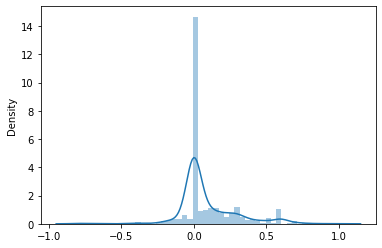

In [48]:
#Visualize the sentiment score
sns.distplot(df.select("sentiment_score").toPandas())
plt.show()

In [49]:
dfPandas = df.toPandas()
dfPandas.head()

,News,Sentiment,News_non_asci,News_fixed_abbrev,News_Cleaned,sentiment_score,Classify
0,- BEIJING XFN-ASIA - Hong Kong-listed Standard...,1,- BEIJING XFN-ASIA - Hong Kong-listed Standard...,- beijing xfn-asia - hong kong-listed standard...,beijing xfn asia hong kong listed standard cha...,-0.03125,Negative
1,- Operating profit rose by 26.9 % to EUR 105.8...,1,- Operating profit rose by 26.9 % to EUR 105.8...,- operating profit rose by 26.9 % to eur 105.8...,operating profit rose by to eur million,0.60000,Positive
2,- Provides summary of the medical equipment pi...,0,- Provides summary of the medical equipment pi...,- provides summary of the medical equipment pi...,provides summary of the medical equipment pipe...,0.00000,Neutral
3,"- So , the sales growth of cars considerably i...",0,"- So , the sales growth of cars considerably i...","- so , the sales growth of cars considerably i...",so the sales growth of cars considerably influ...,0.10000,Positive
4,- UPM-Kymmene upgraded to ` in-line ' from ` u...,1,- UPM-Kymmene upgraded to ` in-line ' from ` u...,- upm-kymmene upgraded to ` in-line ' from ` u...,upm kymmene upgraded to in line from underperf...,0.00000,Neutral
